# Initial setup

Let's import the required libraries and set up global variables for the rest of the script.

In [1]:
# coding: utf-8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpld3
import os
%matplotlib inline

import networkx as nx

Helper function to create a directory under the specified path, gracefully handling errors.

In [2]:
def __mkdir(*args):
    path = os.path.join(*args)
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise
    return path

In [3]:
# Create the project directory holding the downloaded data, serialized dataframes and MetaMap install.
# working_dir = __mkdir(os.path.expanduser("~"), "Medframes")

# Set working directory as the current directory of the ipython notebook
working_dir = os.getcwd()
data_dir = __mkdir(working_dir, "data")
print("Working directory: %s" % working_dir)

Working directory: /Users/Lo/Work/CS109Project


# Load MetaMap & MedEx processing results

We load the previously processed MetaMap and MedEx tag data.

In [4]:
mm = pd.read_pickle(os.path.join(data_dir, 'mm.pckl'))
mm.head()

,ngram,nct_id,criteria_id,ngram_index,score,term,cui,stype,cid
0,"((time, NN),)",NCT00001149,0,0,8.34,Time,C0040223,tmco,[G01.910]
1,"((uncontrolled, VBN), (seizure, NNS), (at, IN))",NCT00001149,0,8,16.21,Seizures,C0036572,sosy,"[C10.228.140.490.631, C10.597.742, C23.888.592..."
2,"((of, IN), (seizure, NNS), (during, IN))",NCT00001149,0,10,16.21,Seizures,C0036572,sosy,"[C10.228.140.490.631, C10.597.742, C23.888.592..."
3,"((seizure, NNS), (at, IN), (the, DT))",NCT00001149,0,11,16.21,Seizures,C0036572,sosy,"[C10.228.140.490.631, C10.597.742, C23.888.592..."
4,"((pattern, NN), (of, IN), (seizure, NNS))",NCT00001149,0,12,16.07,Seizures,C0036572,sosy,"[C10.228.140.490.631, C10.597.742, C23.888.592..."


In [5]:
medex = pd.read_pickle(os.path.join(data_dir, 'medex.pckl'))
medex.head()

,nct_id,criteria_id,drug_name,drug_form,strength,dose,route,frequency,duration,cui,generic_name,term
0,NCT00001205,8,corticosteroid,,,,,,,,corticosteroid,corticosteroid
1,NCT00001205,8,immunosuppressive,,,,,,,,immunosuppressive,immunosuppressive
2,NCT00001205,11,praziquantel,,,,,,,C0032911,praziquantel,praziquantel
3,NCT00001205,11,albendazole,,,,,,,C0001911,albendazole,albendazole
4,NCT00001205,11,methotrexate,,,,,,,C0025677,methotrexate,methotrexate


# Merging MetaMap & MedEx datasets

We map both datasets to the source clinical trial data by merging them by Criteria ID and NCT ID column. Other columns that exists in both datasets are renamed [Column Name]\_x for the MetaMap dataset, and [Column Name]\_y for the MedEx dataset.

In [6]:
merged = pd.merge(mm, medex, on=['criteria_id', 'nct_id'], how='right')
merged.to_pickle(os.path.join(data_dir, 'merged.pckl'))
merged.head()

,ngram,nct_id,criteria_id,ngram_index,score,term_x,cui_x,stype,cid,drug_name,drug_form,strength,dose,route,frequency,duration,cui_y,generic_name,term_y
0,"((immunosuppressive, NNS), (other, JJ), (than,...",NCT00001205,8,0,16.21,Immunosuppressive Agents,C0021081,"imft,phsu",[D27.505.696.477.656],corticosteroid,,,,,,,,corticosteroid,corticosteroid
1,"((for, IN), (therapy, NN))",NCT00001205,8,2,22.57,Therapeutic Aspects,C0039798,ftcn,[x.x.x.x.x.x.x],corticosteroid,,,,,,,,corticosteroid,corticosteroid
2,"((patient, NNS),)",NCT00001205,8,3,8.34,Patients,C0030705,podg,[M01.643],corticosteroid,,,,,,,,corticosteroid,corticosteroid
3,"((child, NNP),)",NCT00001205,8,4,11.49,Child,C0008059,aggp,[M01.060.406],corticosteroid,,,,,,,,corticosteroid,corticosteroid
4,"((corticosteroid, NNS),)",NCT00001205,8,5,11.49,Adrenal Cortex Hormones,C0001617,"horm,phsu,strd",[D06.472.040],corticosteroid,,,,,,,,corticosteroid,corticosteroid


We create a new dataframe dfconn with only terms column (renamed for clarification) from both datasets for extracting the term connections.

In [33]:
merged = pd.read_pickle(os.path.join(data_dir, 'merged.pckl'))
dfconn = merged.loc[:, ['term_x', 'term_y']]
dfconn.term_y = dfconn['term_y'].str.upper()
#dfconn.term_x = dfconn['term_x'].str.lower()
dfconn.term_y = dfconn['term_y'].str.replace(",", ' ').str.replace("'", " " )
dfconn.term_x = dfconn['term_x'].str.replace(",", ' ').str.replace("'", " ")
dfconn = dfconn.rename(columns={'term_x': 'mm', 'term_y': 'md'})
dfconn.to_pickle(os.path.join(data_dir, 'mm-medex-terms.pckl'))
dfconn.head()

,mm,md
0,Immunosuppressive Agents,CORTICOSTEROID
1,Therapeutic Aspects,CORTICOSTEROID
2,Patients,CORTICOSTEROID
3,Child,CORTICOSTEROID
4,Adrenal Cortex Hormones,CORTICOSTEROID


In [34]:
dfconn = pd.read_pickle(os.path.join(data_dir, 'mm-medex-terms.pckl'))

# Visualizing MetaMap and MedEx tag connections

We use NetworkX library in Python to draw the connections between the tags in two datasets. Each tag is treated as a node, and each time a MedEx tag and a MetaMap tag appears on the same row, it counts as one connection (edge) between the two tags (nodes). We are not discussing the connections within the MetaMap tag group or the MedEx tag group here.

We also set a threshold parameter. Only when the percentage of total connections between a MetaMap tag and MedEx tag among all connections of this MedEx tag exceeds a certain number (default is 10% here), it is shown in the visualization. Nodes that are not connected to any other nodes are not shown in the graph.

There are many identical tags (same drugs) in both MetaMap and MedEx datasets. Since the connections between the identical tags do not provide much new information, they are excluded in calculation.

In [72]:
def vis_prep(df, threshold=0.1, start=0, finish=10):
    
    # key: node, value: count (total)
    mm_nodes, md_nodes, edges = {},{},{}
    mm_n = dict(np.sqrt(df.mm.value_counts()))
    md_n = dict(np.sqrt(df.md.value_counts())*4)
    
    for d in df.md.unique()[start:finish]:
        counted = df[df.md==d].mm.value_counts()
        
        # exclude connections between the same tags in medex and metamap
        mask = []
        for i in counted.index:
            if i.upper() in d or i.rstrip("s").upper() in d:
                mask.append(False)
            else:
                mask.append(True)
        counted=counted[mask]
        
        # convert count to to % in total
        conv = counted/float(sum(counted))
        
        # filter out terms above threshold, convert to dict, *100 as edge width
        conv = dict(conv[conv>threshold]*10)
        
        #only add to node list if not empty
        if len(conv) > 0:
            md_nodes[d] = md_n[d]

            #convert key to edge (m, d)    
            for i in conv.keys():
                edges[(d,i)] = conv.pop(i)
                mm_nodes[i] = mm_n[i]
        
    return mm_nodes,md_nodes,edges

We used mpld3 library in Python to make the graph interactive. You can hover over the nodes to see the tag name and zoom in/out.

In [67]:
def draw_mm_medex_vis(mm_nodes, md_nodes, edges, interactive=True, prog="neato"):
    G = nx.Graph()
    fig, ax = plt.subplots(figsize=(12,8))

    for node, size in mm_nodes.iteritems():
        G.add_node(node, cat="mm", s=size)
    
    for node, size in md_nodes.iteritems():
        G.add_node(node, cat="md", s=size)
    
    for (p1,p2), width in edges.iteritems():
        G.add_edge(p1,p2)#, w=width)
    
    color_map = {'md':'r', 'mm':'b'}
    pos = nx.graphviz_layout(G, prog=prog)
    nx.draw_networkx_edges(G, pos, alpha=0.2, ax=ax)#, width=[G.edge[edge]['w'] for edge in G])
    scatter = nx.draw_networkx_nodes(G, pos, alpha=0.6, ax=ax, 
                                     node_color=[color_map[G.node[node]['cat']] for node in G], 
                                     node_size =[G.node[node]['s'] for node in G])
    ax.set_title(str(len(md_nodes))+" MedEx tags (Red) and " + str(len(mm_nodes)) + " connected MetaMap tags (Blue)")
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
    if interactive:
        ax.set_xlabel('(Interactive diagram, hover over the node to see label)')
        labels = G.nodes()
        tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
        mpld3.plugins.connect(fig, tooltip)
        mpld3.enable_notebook()
    else:
        #plt.savefig("mm-md.png")
        plt.show()

Partial dataset visualization.

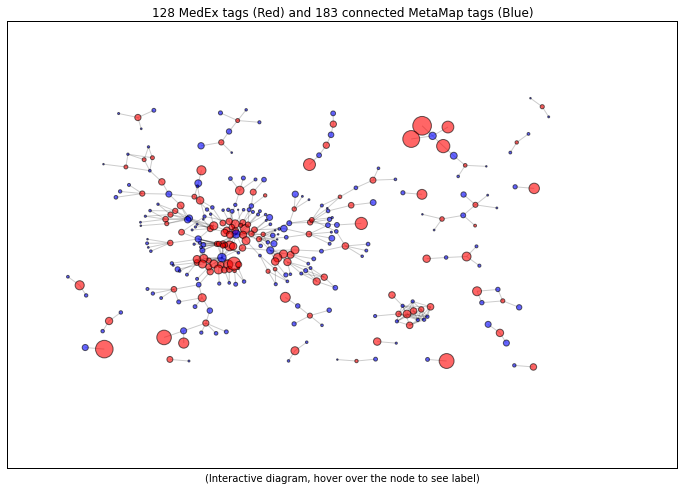

In [73]:
mm_nodes,md_nodes,edges = vis_prep(dfconn, start=None, finish=200)
draw_mm_medex_vis(mm_nodes, md_nodes, edges)

Complete sample dataset visualization. Nodes that are not connected to any other nodes are not shown.

CPU times: user 29 s, sys: 717 ms, total: 29.7 s
Wall time: 1min 1s


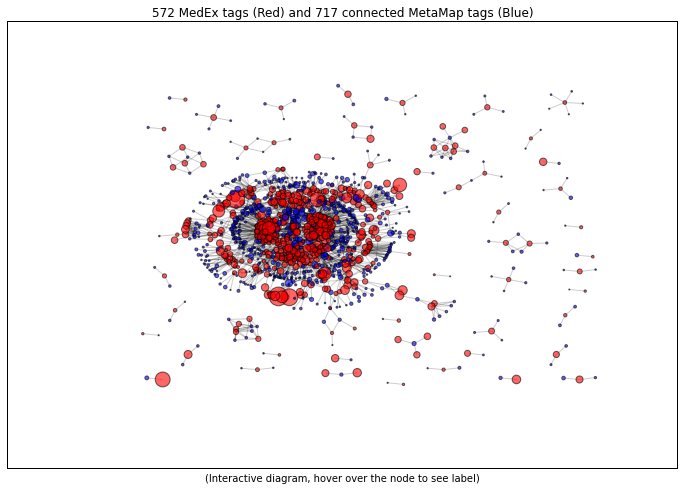

In [69]:
%%time
mm_nodes,md_nodes,edges = vis_prep(dfconn, start=None, finish=None)
draw_mm_medex_vis(mm_nodes, md_nodes, edges)